In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import statsmodels.api as sm ##qq plots
import numpy as np

import utils.multicrop_dataset as multicrop_dataset
import utils.architecture as architecture

tf.random.set_seed(0)
np.random.seed(0)

options = tf.data.Options()
options.experimental_optimization.noop_elimination = True             # eliminate no-op transformations
tf.compat.v1.data.experimental.OptimizationOptions.map_vectorization = True    # vectorize map transformations
options.experimental_optimization.apply_default_optimizations = True  # apply default graph optimizations
options.experimental_deterministic = True                            # False disable deterministic order
options.threading.max_intra_op_parallelism = 1           # overrides the maximum degree of intra-op parallelism 

2024-07-10 11:44:47.310377: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
import xarray as xr
import numpy as np
from time import sleep

def open_nc(file_path):

    try:
        ds = xr.open_dataset(file_path)

    except Exception as e:
        print(f"Error opening file: {e}")
        return 

    else:
        return ds
    
def get_values(variable, file= 'data/msl_t2m_1983_2023.nc',wind = 5, quantile=False):
    #just to save process

    ds = open_nc(file)
    df = ds[variable].values

    if quantile:
        max_o = np.quantile(df,0.99)
        min_o = np.quantile(df,0.1)

        df = np.clip(df, min_o, max_o)

    else:
        min_o = np.min(df)
        max_o = np.max(df)

    norm_imgs = (df - min_o)/(max_o -min_o)

    time, lat, long = norm_imgs.shape

    norm_imgs = norm_imgs.reshape(int(time/wind), wind, lat, long)
    norm_imgs = np.transpose(norm_imgs, (0, 2, 3, 1))

    # np.save(f'data/{variable}',norm_imgs,allow_pickle=False)

    return norm_imgs

data = get_values('t2m')

In [12]:
BS = 256
SIZE_CROPS = [50, 32]  
NUM_CROPS= [2,3]

#SCALE FOR CROPPING
MIN_SCALE = [0.7, 0.5]
MAX_SCALE = [1., 0.7]

PROTOTYPES = 30
PROPORTIONS = [] #to not use proportions declare it as empty list

#check
if len(PROPORTIONS):
    PROTOTYPES = len(PROPORTIONS)

MODEL_TAG  = ''

In [13]:
# data = np.load('data/test.npy')
data_tensors = tf.data.Dataset.from_tensor_slices(data) 

# Get multiple data loaders
trainloaders = multicrop_dataset.get_multires_dataset(data_tensors,
    size_crops=SIZE_CROPS,
    num_crops=NUM_CROPS,
    min_scale=MIN_SCALE,
    max_scale=MAX_SCALE,
    options=options)

trainloaders_zipped = tf.data.Dataset.zip(trainloaders)

trainloaders_zipped = (
        trainloaders_zipped
        .batch(BS)
        .prefetch( tf.data.experimental.AUTOTUNE)
    )

2024-07-10 11:48:48.683817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79195 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0001:00:00.0, compute capability: 8.0


2024-07-10 11:49:12.246166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_30' with dtype float and shape [23960,143,142,5]
	 [[{{node Placeholder/_30}}]]
2024-07-10 11:49:12.246519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [23960,143,142,5]
	 [[{{node Placeholder/_0}}]]


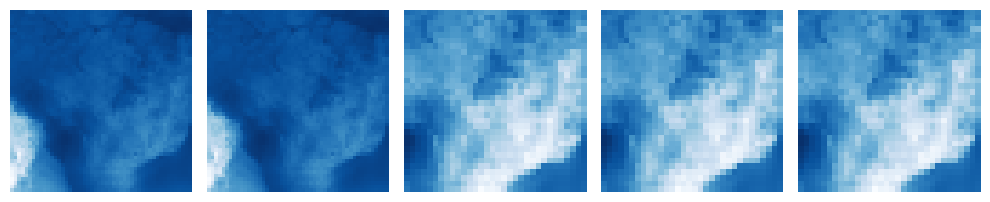

In [14]:
images = [i[3] for i in next(iter(trainloaders_zipped))]

fig, axes = plt.subplots(1, 5, figsize=(10, 7))

for ax, img in zip(axes.ravel(), images):
    ax.imshow(img,cmap='Blues')
    ax.axis('off')


for ax in axes.ravel()[len(images):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
feature_backbone = architecture.get_resnet_backbone()
projection_prototype = architecture.get_projection_prototype(prototype_dimension = PROTOTYPES)

In [16]:
decay_steps = 1000

lr_decayed_fn = tf.keras.experimental.CosineDecay(
    initial_learning_rate=0.1, decay_steps=decay_steps)

opt = tf.keras.optimizers.SGD(learning_rate=lr_decayed_fn)

In [17]:
# tf.keras.backend.clear_session()

In [16]:
# feature_backbone.load_weights(f'model_weights/feature2d_{PROTOTYPES}.h5')
# projection_prototype.load_weights(f'model_weights/proj2d_{PROTOTYPES}.h5')

In [18]:
epoch_wise_loss, models_tr = architecture.train_swav(feature_backbone,projection_prototype,
                                        trainloaders_zipped,opt,
                                        crops_for_assign=[0, 1],temperature=0.1,epochs=100,
                                        n_crops = NUM_CROPS, proto_proportions = PROPORTIONS,model_name=str(PROTOTYPES))

feature_backbone_weights = feature_backbone.get_weights()

  0%|          | 0/94 [00:00<?, ?it/s]2024-07-10 11:49:39.347273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2024-07-10 11:49:39.431887: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-10 11:49:43.118538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


2024-07-10 11:50:04.301875: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x5e4cd262e600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-10 11:50:04.301909: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-07-10 11:50:04.318435: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-07-10 11:50:04.344304: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 94/94 [01:08<00:00,  1.37it/s, loss=3.203]


epoch: 1 loss: 2.979
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.40it/s, loss=2.676]


epoch: 2 loss: 2.597
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.483]


epoch: 3 loss: 2.327
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.469]


epoch: 4 loss: 2.139
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.40it/s, loss=2.282]


epoch: 5 loss: 1.999
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.394]


epoch: 6 loss: 1.893
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.354]


epoch: 7 loss: 1.806
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.239]


epoch: 8 loss: 1.739
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.471]


epoch: 9 loss: 1.683
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.223]


epoch: 10 loss: 1.633
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.531]


epoch: 11 loss: 1.595
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.570]


epoch: 12 loss: 1.564
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.606]


epoch: 13 loss: 1.538
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.400]


epoch: 14 loss: 1.513
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.607]


epoch: 15 loss: 1.493
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.330]


epoch: 16 loss: 1.476
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.416]


epoch: 17 loss: 1.459
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.33it/s, loss=2.601]


epoch: 18 loss: 1.445
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.605]


epoch: 19 loss: 1.433
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.467]


epoch: 20 loss: 1.421
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.36it/s, loss=2.574]


epoch: 21 loss: 1.411
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.775]


epoch: 22 loss: 1.401
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.348]


epoch: 23 loss: 1.393
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.418]


epoch: 24 loss: 1.385
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.36it/s, loss=2.437]


epoch: 25 loss: 1.379
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.352]


epoch: 26 loss: 1.372
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.40it/s, loss=2.425]


epoch: 27 loss: 1.365
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.263]


epoch: 28 loss: 1.359
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.480]


epoch: 29 loss: 1.354
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.493]


epoch: 30 loss: 1.348
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.484]


epoch: 31 loss: 1.343
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.36it/s, loss=2.381]


epoch: 32 loss: 1.338
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.526]


epoch: 33 loss: 1.334
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.537]


epoch: 34 loss: 1.330
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.33it/s, loss=2.537]


epoch: 35 loss: 1.326
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.630]


epoch: 36 loss: 1.323
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.437]


epoch: 37 loss: 1.320
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.477]


epoch: 38 loss: 1.317
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.40it/s, loss=2.537]


epoch: 39 loss: 1.315
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.215]


epoch: 40 loss: 1.312
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.459]


epoch: 41 loss: 1.309
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.366]


epoch: 42 loss: 1.307
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.33it/s, loss=2.562]


epoch: 43 loss: 1.304
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.582]


epoch: 44 loss: 1.302
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.444]


epoch: 45 loss: 1.300
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.511]


epoch: 46 loss: 1.298
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.505]


epoch: 47 loss: 1.297
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.456]


epoch: 48 loss: 1.295
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.439]


epoch: 49 loss: 1.293
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.672]


epoch: 50 loss: 1.291
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.350]


epoch: 51 loss: 1.289
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.515]


epoch: 52 loss: 1.288
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.484]


epoch: 53 loss: 1.287
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.278]


epoch: 54 loss: 1.285
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.662]


epoch: 55 loss: 1.284
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.33it/s, loss=2.487]


epoch: 56 loss: 1.283
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.577]


epoch: 57 loss: 1.281
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.401]


epoch: 58 loss: 1.280
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.630]


epoch: 59 loss: 1.279
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.40it/s, loss=2.648]


epoch: 60 loss: 1.278
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.559]


epoch: 61 loss: 1.277
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.385]


epoch: 62 loss: 1.276
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.605]


epoch: 63 loss: 1.274
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.492]


epoch: 64 loss: 1.273
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.505]


epoch: 65 loss: 1.272
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.369]


epoch: 66 loss: 1.271
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.469]


epoch: 67 loss: 1.270
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.567]


epoch: 68 loss: 1.269
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.377]


epoch: 69 loss: 1.268
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.488]


epoch: 70 loss: 1.267
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.332]


epoch: 71 loss: 1.266
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.500]


epoch: 72 loss: 1.266
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.470]


epoch: 73 loss: 1.264
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.32it/s, loss=2.349]


epoch: 74 loss: 1.264
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.476]


epoch: 75 loss: 1.263
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.323]


epoch: 76 loss: 1.262
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.33it/s, loss=2.597]


epoch: 77 loss: 1.261
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.478]


epoch: 78 loss: 1.260
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.548]


epoch: 79 loss: 1.260
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.300]


epoch: 80 loss: 1.259
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.445]


epoch: 81 loss: 1.258
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.420]


epoch: 82 loss: 1.258
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.521]


epoch: 83 loss: 1.257
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.386]


epoch: 84 loss: 1.257
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.498]


epoch: 85 loss: 1.256
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.533]


epoch: 86 loss: 1.256
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.525]


epoch: 87 loss: 1.255
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.437]


epoch: 88 loss: 1.255
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.37it/s, loss=2.512]


epoch: 89 loss: 1.254
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.473]


epoch: 90 loss: 1.254
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.326]


epoch: 91 loss: 1.253
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.39it/s, loss=2.358]


epoch: 92 loss: 1.253
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.423]


epoch: 93 loss: 1.252
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.577]


epoch: 94 loss: 1.252
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.462]


epoch: 95 loss: 1.251
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.38it/s, loss=2.643]


epoch: 96 loss: 1.250
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.40it/s, loss=2.478]


epoch: 97 loss: 1.250
Saving weights


100%|██████████| 94/94 [00:27<00:00,  3.36it/s, loss=2.417]


epoch: 98 loss: 1.250
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.35it/s, loss=2.481]


epoch: 99 loss: 1.249
Saving weights


100%|██████████| 94/94 [00:28<00:00,  3.34it/s, loss=2.451]


epoch: 100 loss: 1.249
Saving weights


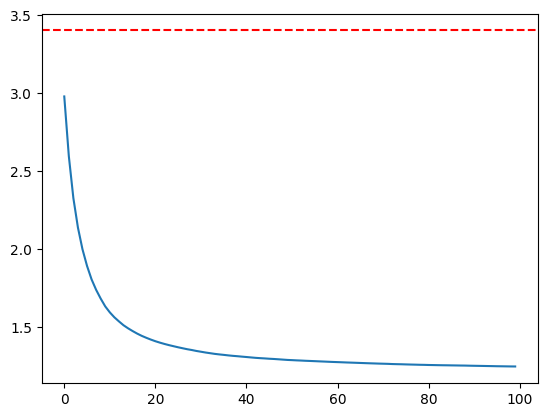

In [21]:
plt.plot(epoch_wise_loss, label='Epoch-wise Loss')
plt.axhline(y=np.log(PROTOTYPES), color='r', linestyle='--', label='ln(#prototypes)')

plt.show()

## Get assigments:

In [22]:
from scipy.special import softmax

In [23]:
final_data = []
for sample in data:

    for v in range(sample.shape[-1]):
        final_data.append(sample[:,:,v])

In [24]:
blocks=100
size = int(len(final_data)/blocks)

for i in range(blocks):

    embeddings_ = feature_backbone(np.asarray(final_data)[i*size:(i+1)*size])
    projection_, prototype_ = projection_prototype(embeddings_)

    if i == 0:
        prototype=np.asarray(prototype_)
    else:
        prototype=np.concatenate([prototype,np.asarray(prototype_)])

prototype = np.asarray(prototype)
del projection_,embeddings_

assignments = np.argmax(softmax(prototype),axis=1)
np.save(f'model_weights/assignments_{PROTOTYPES}',assignments,allow_pickle=False)

2024-07-10 12:50:00.869427: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.


In [51]:
# unique, counts = np.unique(assignments, return_counts=True)
# print(np.asarray((unique, counts)).T)

## Simple plots

In [53]:
min_samples= 500
max_samples= len(final_data)

colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 1, num=PROTOTYPES)]
test_data_list = np.asarray(final_data)


Cluster: 0 Shape: (5807, 143, 142) Avg: 0.75769144 Std: 0.076100044
Cluster: 1 Shape: (4736, 143, 142) Avg: 0.67778045 Std: 0.06648998
Cluster: 2 Shape: (1455, 143, 142) Avg: 0.6575538 Std: 0.07595157
Cluster: 3 Shape: (2795, 143, 142) Avg: 0.73277396 Std: 0.08492494
Cluster: 4 Shape: (1607, 143, 142) Avg: 0.67580706 Std: 0.08355046
Cluster: 5 Shape: (3317, 143, 142) Avg: 0.64620864 Std: 0.087353274
Cluster: 6 Shape: (1894, 143, 142) Avg: 0.65292615 Std: 0.09303505
Cluster: 7 Shape: (1363, 143, 142) Avg: 0.70680887 Std: 0.0826521
Cluster: 8 Shape: (2982, 143, 142) Avg: 0.6663025 Std: 0.07805619
Cluster: 9 Shape: (3507, 143, 142) Avg: 0.6835069 Std: 0.07289976
Cluster: 11 Shape: (12191, 143, 142) Avg: 0.681385 Std: 0.0685107
Cluster: 13 Shape: (2217, 143, 142) Avg: 0.7381255 Std: 0.051963862
Cluster: 14 Shape: (2028, 143, 142) Avg: 0.75223637 Std: 0.057183843
Cluster: 15 Shape: (2420, 143, 142) Avg: 0.67052317 Std: 0.067094736
Cluster: 16 Shape: (672, 143, 142) Avg: 0.7179454 Std: 0.051

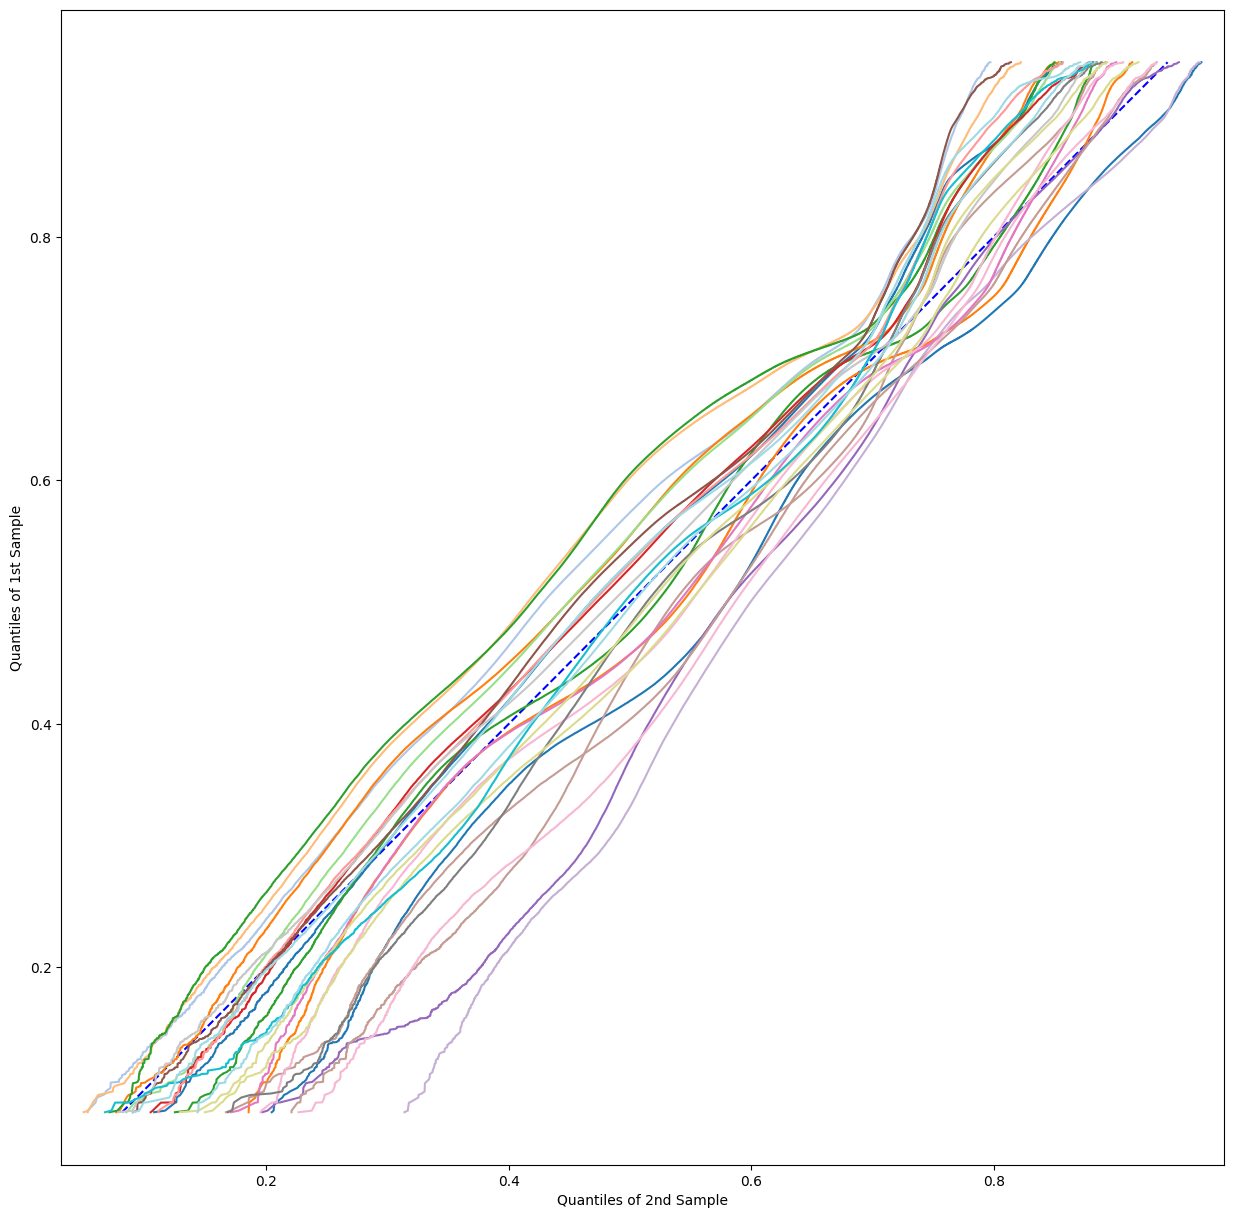

In [56]:
random_samples_ids = np.random.choice(range(test_data_list.shape[0]),size=min_samples) #random samples to QQPLOT
colors_c = [plt.colormaps['tab20'](c) for c in np.linspace(0, 1, num=PROTOTYPES)]

fig, ax = plt.subplots(figsize=(15, 15))

pplot  = sm.ProbPlot(data=test_data_list[random_samples_ids].ravel())
pplot.qqplot(other=pplot,ax=ax, marker='', linestyle='dashed',label= 'self') #45 line

for num, cluster in enumerate(range(PROTOTYPES)): #iterates over each cluster (uses num to get new color)
    
    cur_cluster = test_data_list[assignments==cluster].copy()
    cur_cluster_shape = cur_cluster.shape

    if (cur_cluster_shape[0]>min_samples) and (cur_cluster_shape[0]<max_samples):
        
#         if num in [3,11]:
        #show cluster stats
        print('Cluster:',cluster,'Shape:', cur_cluster_shape,  'Avg:',np.mean(cur_cluster.ravel()),  'Std:', np.std(cur_cluster.ravel()))

        random_samples_ids = np.random.choice(range(cur_cluster_shape[0]),size=min_samples) #random select samples from current cluster

        cur_color = colors_c[num] 
        pplot.qqplot(other=cur_cluster[random_samples_ids].ravel(),ax=ax,marker='', linestyle='solid', color=cur_color,
                        label= f'{cluster}: {cur_cluster_shape[0]}')

#         else:
#             random_samples_ids = np.random.choice(range(cur_cluster_shape[0]),size=min_samples) #random select samples from current cluster

#             pplot.qqplot(other=cur_cluster[random_samples_ids].ravel(),ax=ax,marker='', linestyle='solid', color='lightgrey',
#                           label= f'{cluster}: {cur_cluster_shape[0]}')

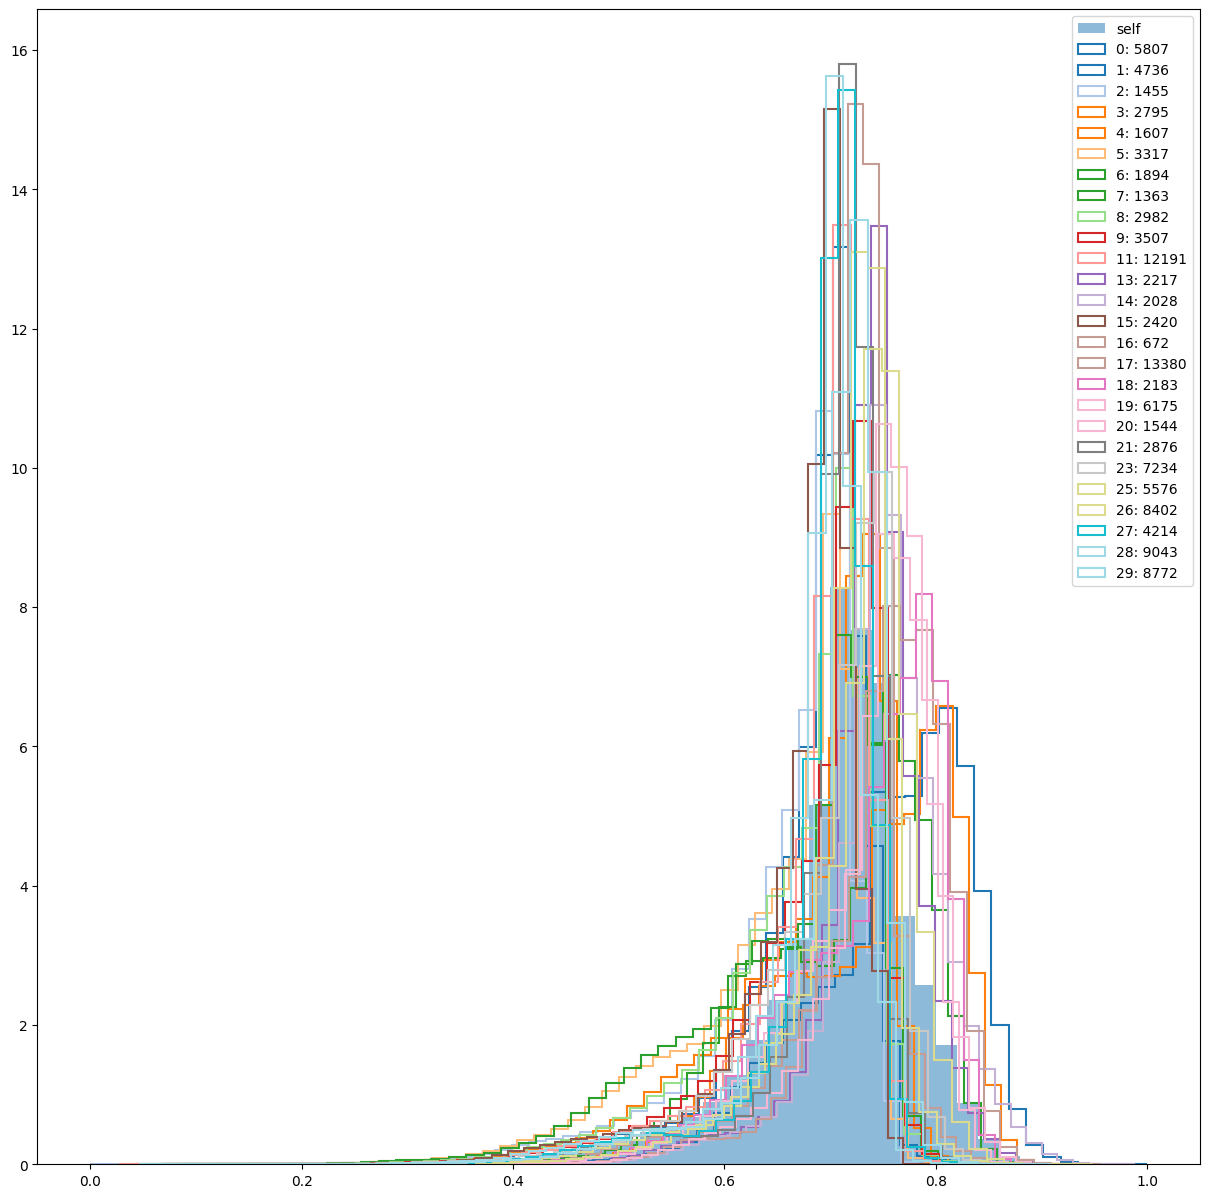

In [50]:
n_bins = 50

fig, ax = plt.subplots(figsize=(15, 15))

plt.hist(test_data_list.ravel(),density=True,bins=n_bins,alpha = 0.5,label= 'self')

for num, cluster in enumerate(range(PROTOTYPES)):
    

    cur_cluster = test_data_list[assignments==cluster].copy()
    cur_cluster_shape = cur_cluster.shape

    if (cur_cluster_shape[0]>min_samples) and (cur_cluster_shape[0]<max_samples):
            
#         if num in []:

            plt.hist(cur_cluster.ravel(),density=True,bins=n_bins,histtype='step',color=colors_c[num],label= f'{cluster}: {cur_cluster_shape[0]}',linewidth=1.5)
        
#         else:
#                  plt.hist(cur_cluster.ravel(),density=True,bins=n_bins,histtype='step',color='lightgrey',label= f'{cluster}: {cur_cluster_shape[0]}',linewidth=0.5)
        

plt.legend()